# Laborarbeit Künstliche Intelligenz

## Thema :  Evolutionary Computing & Constraint Satisfaction Problems

### Namen der Studierenden: Michael Dehm & Tim Teller

(Hinweis: Es sind Namen anzugeben und keine Matrikelnummern. Matrikelnummern werden ausschließlich bei Klausuren zur Anonymisierung verwendet)

# Installs

In [1]:
%pip install seaborn matplotlib pandas deap python-constraint ortools prettytable

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from collections import Counter
import random
from copy import deepcopy
from ortools.sat.python import cp_model

# Einlesen der Konfigurations-Datei für Ihre Aufgabe
def load_configuration():
    with open('configuration_003.json', 'r') as file:
        return json.load(file)

configuration = load_configuration()

load c:\Users\b43579\Code\kuenstliche_intelligenz\.venv\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\b43579\Code\kuenstliche_intelligenz\.venv\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\b43579\Code\kuenstliche_intelligenz\.venv\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\b43579\Code\kuenstliche_intelligenz\.venv\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\b43579\Code\kuenstliche_intelligenz\.venv\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\b43579\Code\kuenstliche_intelligenz\.venv\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\b43579\Code\kuenstliche_intelligenz\.venv\Lib\site-packages\ortools\.libs\ortools.dll...


#### Die Konfiguration betrachten

In [3]:
def print_configuration(configuration):
    
    print("\nAusführliche Konfiguration:\n")
    
    print("Studiengänge und Kursgruppenanzahlen:")
    for program, groups in configuration['study_programs'].items():
        print(f"- {program}: {groups} Kursgruppen")
    
    print("\nPrüfungswochen und zugeordnete Studiengänge:")
    for week, programs in configuration['exam_weeks'].items():
        print(f"- {week}: {', '.join(programs)}")
    
    print("\nZeitslots mit Beliebtheit:")
    for slot, details in configuration['time_slots'].items():
        print(f"- {slot} ({details['time']}): Beliebtheit {details['popularity']}")
    
    print("\nTage der Woche mit Beliebtheit:")
    for day, details in configuration['days'].items():
        print(f"- {day}: Beliebtheit {details['popularity']}")
    
    print("\nBeliebtheit von Raumzuteilungen:")
    print(f"- Parallel zugeteilte Räume: Beliebtheit {configuration['room_popularity']['parallel']}")
    print(f"- Zeitlich hintereinander zugeteilte Räume: Beliebtheit {configuration['room_popularity']['sequential']}")


In [4]:
print_configuration(configuration)


Ausführliche Konfiguration:

Studiengänge und Kursgruppenanzahlen:
- INF: 6 Kursgruppen
- ET: 5 Kursgruppen
- ES: 1 Kursgruppen
- MB: 2 Kursgruppen
- MT: 3 Kursgruppen
- WIW: 3 Kursgruppen

Prüfungswochen und zugeordnete Studiengänge:
- Week 1: MB, MT, ES, ET, WIW, INF
- Week 2: MB, ET, INF, MT, WIW, ES
- Week 3: WIW, INF, ES
- Week 4: WIW, ET, ES, MB, MT, INF
- Week 5: MB, WIW, ET, INF
- Week 6: MT, ES, ET, INF
- Week 7: ET, WIW, MB, INF, ES, MT
- Week 8: MT, INF, ES

Zeitslots mit Beliebtheit:
- Slot A (8:00-10:00): Beliebtheit 5
- Slot B (10:30-12:30): Beliebtheit 6
- Slot C (13:00-15:00): Beliebtheit 4
- Slot D (15:30-17:30): Beliebtheit 1

Tage der Woche mit Beliebtheit:
- Monday: Beliebtheit 6
- Tuesday: Beliebtheit 5
- Wednesday: Beliebtheit 6
- Thursday: Beliebtheit 5
- Friday: Beliebtheit 3

Beliebtheit von Raumzuteilungen:
- Parallel zugeteilte Räume: Beliebtheit 7
- Zeitlich hintereinander zugeteilte Räume: Beliebtheit 5


Die hier angegebenen Beliebtheitswerte fließen in die Bewertungsfunktion ein, die von Ihnen noch anzupassen ist.

In [5]:
# Nur als Beispiel und zur Veranschaulichung ... zufällige Zuteilung generieren
import random


def random_assign_timeslots(week_number, configuration):
    study_programs = configuration['exam_weeks'].get(f"Week {week_number}", [])
    
    # Struktur für die Zuteilung: Dict of days containing list of slots each with two rooms
    schedule = {day: {slot: [None, None] for slot in configuration['time_slots']} for day in configuration['days']}
    
    # Erstelle eine Liste aller Zeit-Slot Kombinationen für eine Woche
    time_slot_combinations = [(day, slot) for day in schedule for slot in schedule[day]]
    
    # Verteile die Studiengänge zufällig, bis alle Slots gefüllt sind
    for (day, slot) in time_slot_combinations:
        for i in range(2):  # Zwei Räume pro Slot
            program = random.choice(study_programs)
            schedule[day][slot][i] = program
    
    return schedule

def print_schedule(schedule):
    days = list(schedule.keys())
    slots = list(schedule[days[0]].keys())
    
    # Erste Zeile: Tage der Woche
    day_line = "Zeit / Tage  " + "".join([f"{day:^20}" for day in days])
    
    # Zweite Zeile: Räume unter jedem Tag anzeigen
    room_line = " " * 12 + "".join([f"{'R1':^10}{'R2':^10}" for _ in days])
    
    line_length = len(day_line)
    line = "-" * line_length
    
    print(line)
    print(day_line)
    print(room_line)
    print(line)

    for slot in slots:
        print(f"{slot:^10} ", end="")
        for day in days:
            rooms = schedule[day][slot]
            r1, r2 = rooms[0], rooms[1]
            print(f"{r1:^10}{r2:^10}", end="")
        print()
    print(line)



## Aufgabenteil 1: Evolutionary Computing

Entwerfen Sie ein KI Modell auf Basis des Evolutionary Computing und setzen
Sie dieses als Jupyter Notebook um. Insbesondere werden eine geeignete Repräsentation
sowie eine geeignete Fitness-Funktion benötigt.

### 1. Modell anlegen

- Individuenformat festlegen
- Fitnessfunktion festlegen
- Mutation und Crossover geeignet wählen

#### Erläuterung / Begründung zur Modellierung von Individuen
Die Prüfungspläne der einzelnen Wochen wurden als Individuen definiert und jeweils in wöchentliche Populationen dem evolutionären Optimierungsalgorithmus unterzogen.
Da das Evolutionary Computing nativ und ohne Framework implementiert wurde, war keine separate Modellierung eines Individuums erforderlich sondern die vorgegebene Struktur konnte direkt verwendet werden.

### Fittnesfunktion, Crossoverfunktion und Mutationsfunktion

In [6]:
# Berechnet die Varianz über die Werte der Studiengänge zur Bestimmung der Unfairness
def calc_unfairness(scores_by_study_program):
    vals = list(scores_by_study_program.values())
    var = np.var(vals)
    return var

# Bewertungsfunktion (Fitness) eines gegebenen Prüfungsplans
def calc_fitness(
        schedule,
        week_number,
        configuration,
        parallel_popularity_score_factor=1,
        consecutive_popularity_score_factor=1,
        day_popularity_score_factor=1,
        slot_popularity_score_factor=1,
        unfairness_parallel_popularity_score_factor=1,
        unfairness_consecutive_popularity_score_factor=1,
        unfairness_day_popularity_score_factor=1,
        unfairness_slot_popularity_score_factor=1,
        unproportional_slots_penalty_factor=10,
        unfairness_slot_not_every_day_factor=1,
        slot_not_every_day_penalty_factor=10,
        early_late_slots_penalty_factor=10
        ):

    # Berechnung der Gesamtanzahl verfügbarer Slots
    day_num = len(configuration['days'])
    room_num = 2
    slot_num = len(configuration['time_slots'])
    total_slots = day_num*room_num*slot_num

    # Relevante Studiengänge und deren Kursanzahl für die Woche
    programs_this_week = configuration['exam_weeks'][f'Week {week_number}']
    courses_per_program = configuration['study_programs']

    # Gesamtzahl der Kurse in dieser Woche
    total_courses = 0
    for study_program in programs_this_week:
        total_courses += courses_per_program[study_program]
    
    # Berechnung der proportional zuzuweisenden Slots pro Studiengang
    proportional_slots = {}
    for study_program in programs_this_week:
        proportional_slots[study_program] = courses_per_program[study_program]/total_courses * total_slots
    
    # Zählen der tatsächlichen Slotbelegungen
    all_values = []
    for day_slots in schedule.values():
        for slot in day_slots.values():
            all_values.extend(slot)
    count = Counter(all_values)
    actual_slots = dict(count)

    # Strafwert für unproportionale Slotverteilung
    unproportional_slots_penalty = 0
    for study_program in actual_slots:
        unproportional_slots_penalty += np.abs(actual_slots[study_program]-proportional_slots[study_program])
    

    # Initialisierung von Beliebtheitsscores für verschiedene Kriterien
    parallel_popularity_scores_by_study_program = {}
    consecutive_popularity_scores_by_study_program = {}
    day_popularity_scores_by_study_program = {}
    slot_popularity_scores_by_study_program = {}
    for study_program in programs_this_week:
        parallel_popularity_scores_by_study_program[study_program] = 0
        consecutive_popularity_scores_by_study_program[study_program] = 0
        day_popularity_scores_by_study_program[study_program] = 0
        slot_popularity_scores_by_study_program[study_program] = 0

    # Bewertung paralleler Prüfungen großer Studiengänge
    big_course_parallel_popularity = configuration['room_popularity']['parallel']
    for day in schedule:
        for slot in schedule[day]:
            parallel_rooms_by_study_program = Counter(schedule[day][slot])
            for study_program in dict(parallel_rooms_by_study_program):
                if courses_per_program[study_program] > 1 and parallel_rooms_by_study_program[study_program] > 1:
                    parallel_popularity_scores_by_study_program[study_program] += big_course_parallel_popularity

    # Bewertung aufeinanderfolgender Prüfungen
    course_consecutive_popularity = configuration['room_popularity']['sequential']
    for day in schedule:
        for i in range(1,len(schedule[day])):
            prev_key = list(schedule[day])[i-1]
            key = list(schedule[day])[i]
            prev_slot = schedule[day][prev_key]
            slot = schedule[day][key]
            for k in range(0,room_num):
                if(slot[k] in prev_slot):
                    consecutive_popularity_scores_by_study_program[slot[k]] += course_consecutive_popularity
    
    # Bewertung der Tages- und Slot-Beliebtheit
    for day in schedule:
        for slot in schedule[day]:
            for study_program in schedule[day][slot]:
                day_popularity = configuration['days'][day]['popularity']
                slot_popularity = configuration['time_slots'][slot]['popularity']
                day_popularity_scores_by_study_program[study_program] += day_popularity
                slot_popularity_scores_by_study_program[study_program] += slot_popularity
    
    # Normierung der Beliebtheitsscores
    for study_program in programs_this_week:
        parallel_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]
        consecutive_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]
        day_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]
        slot_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]

    # Ausschluss von Studiengängen mit nur einem Kurs aus Parallelwertungen
    for study_program in programs_this_week:
        if courses_per_program[study_program] <= 1:
            del parallel_popularity_scores_by_study_program[study_program]

    # Zählung der Prüfungstage pro Studiengang
    number_of_days_by_program = {}
    for program in programs_this_week:
        number_of_days_by_program[program] = 0
    for day in schedule:
        programs_this_day = []
        for slot in schedule[day]:
            for program in schedule[day][slot]:
                programs_this_day.append(program)
        for program in number_of_days_by_program:
            if program in programs_this_day:
                number_of_days_by_program[program] += 1
    
    # Strafwert für Studiengänge, die nicht an allen Tagen Prüfungen haben
    slot_not_every_day_penalty = day_num*len(programs_this_week)
    for program in number_of_days_by_program:
        slot_not_every_day_penalty -= number_of_days_by_program[program]


    # Strafwert für Prüfungen am Ende eines Tages und direkt zu Beginn des Folgetages
    early_late_slots_penalty = 0
    for i in range(1,len(schedule)):
        prev_day = list(schedule)[i-1]
        day = list(schedule)[i]
        last_slot_prey_day = list(schedule[prev_day].values())[-1]
        first_slot_this_day = list(schedule[day].values())[0]
        for program in last_slot_prey_day:
            if program in first_slot_this_day:
                early_late_slots_penalty += 1

    # Berechnung der Unfairness für jede Beliebtheitsmetrik
    unfairness_slot_not_every_day = calc_unfairness(number_of_days_by_program)
    unfairness_parallel_popularity_scores = calc_unfairness(parallel_popularity_scores_by_study_program)
    unfairness_consecutive_popularity_scores = calc_unfairness(consecutive_popularity_scores_by_study_program)
    unfairness_day_popularity_scores = calc_unfairness(day_popularity_scores_by_study_program)
    unfairness_slot_popularity_scores = calc_unfairness(slot_popularity_scores_by_study_program)

    # Summierung der Beliebtheitsscores
    parallel_popularity_score_total = sum(list(parallel_popularity_scores_by_study_program.values()))
    consecutive_popularity_score_total = sum(list(consecutive_popularity_scores_by_study_program.values()))
    day_popularity_score_total = sum(list(day_popularity_scores_by_study_program.values()))
    slot_popularity_score_total = sum(list(slot_popularity_scores_by_study_program.values()))

    # Gesamtscore unter Berücksichtigung positiver und negativer Faktoren
    total_score = (parallel_popularity_score_total * parallel_popularity_score_factor) \
                + (consecutive_popularity_score_total * consecutive_popularity_score_factor) \
                + (day_popularity_score_total * day_popularity_score_factor) \
                + (slot_popularity_score_total * slot_popularity_score_factor) \
                - (unfairness_parallel_popularity_scores * unfairness_parallel_popularity_score_factor) \
                - (unfairness_consecutive_popularity_scores * unfairness_consecutive_popularity_score_factor) \
                - (unfairness_day_popularity_scores * unfairness_day_popularity_score_factor) \
                - (unfairness_slot_popularity_scores * unfairness_slot_popularity_score_factor) \
                - (unproportional_slots_penalty * unproportional_slots_penalty_factor) \
                - (unfairness_slot_not_every_day * unfairness_slot_not_every_day_factor) \
                - (slot_not_every_day_penalty * slot_not_every_day_penalty_factor) \
                - (early_late_slots_penalty * early_late_slots_penalty_factor)


    return total_score

# Führt Mutation auf dem Prüfungsplan aus (Swap oder Ersetzung)
def mutate_schedule(schedule, week_number, configuration, mutation_probability=0.2):
    from copy import deepcopy
    import random

    room_num = 2
    new_schedule = deepcopy(schedule)
    programs_this_week = configuration['exam_weeks'][f'Week {week_number}']

    # Erzeuge alle belegbaren Positionen im Plan
    all_positions = [
        (day, slot, room)
        for day in new_schedule
        for slot in new_schedule[day]
        for room in range(room_num)
    ]

    # Mit gegebener Wahrscheinlichkeit Mutation durchführen
    if random.random() < mutation_probability:
        mutation_type = random.choice(['swap', 'replace'])

        if mutation_type == 'swap':
            pos1, pos2 = random.sample(all_positions, 2)
            d1, s1, r1 = pos1
            d2, s2, r2 = pos2
            new_schedule[d1][s1][r1], new_schedule[d2][s2][r2] = \
                new_schedule[d2][s2][r2], new_schedule[d1][s1][r1]

        elif mutation_type == 'replace':
            d, s, r = random.choice(all_positions)
            new_schedule[d][s][r] = random.choice(programs_this_week)

    return new_schedule

# Führt Kreuzung zweier Elternpläne durch (ab einem zufälligen Tag)
def crossover_schedules(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    days = list(parent1.keys())
    crossover_day = random.choice(days)

    # Kopiere ab crossover_day die Tagespläne vom jeweils anderen Elternteil
    switch = False
    for day in days:
        if day == crossover_day:
            switch = True
        if switch:
            child1[day], child2[day] = deepcopy(parent2[day]), deepcopy(parent1[day])

    return child1, child2

### Erläuterung / Begründung zur Fitnessfunktion
Die Fittnessfunktion wurde so entwickelt, dass sie direkt mit den Prüfungsplänen einer Woche arbeiten kann. Hierbei werden alle kriterein aus der aufgabenstellung berücksichtigt:

Sie bewertet einen gegebenen Prüfungsplan basierend auf den Kriterien aus der Aufgabenstellung. Ziel ist die Maximierung eines Gesamtwerts, wobei positive Faktoren belohnt und negative sanktioniert werden.

Positive Faktoren:
- Parallele Prüfungen großer Studiengänge: Häufige gleichzeitige Prüfungen für große Studiengänge werden bevorzugt (Effizienz).
- Aufeinanderfolgende Prüfungen: Wenn ein Studiengang aufeinanderfolgende Prüfungen hat, wird dies gewertet.
- Tages- und Slot-Beliebtheit: Beliebte Wochentage und Tageszeiten führen zu höheren Scores.

Negative Faktoren:
- Unfairness in der Slotverteilung: Varianz der vergebenen Slots zwischen Studiengängen wird als Unfairness interpretiert.
- Unfaire Verteilung der Beliebtheitsscores: Hohe Varianz in paralleler/sequenzieller/Tages-/Slot-Beliebtheit wird bestraft.
- Unproportionale Slotvergabe: Abweichung von der idealproportionalen Verteilung basierend auf Kursanzahl wird bestraft.
- Nicht alle Tage genutzt: Studiengänge mit Prüfungen an zu wenigen Tagen werden negativ gewertet.
- Prüfungen am Tagesende und Folgetagesbeginn: Unmittelbare Wiederholungen werden sanktioniert.

### Evolution

In [7]:
import random
import matplotlib.pyplot as plt


def run_evolution(
        population_size,
        generations,
        parallel_popularity_score_factor=1,
        consecutive_popularity_score_factor=1,
        day_popularity_score_factor=1,
        slot_popularity_score_factor=1,
        unfairness_parallel_popularity_score_factor=1,
        unfairness_consecutive_popularity_score_factor=1,
        unfairness_day_popularity_score_factor=1,
        unfairness_slot_popularity_score_factor=1,
        unproportional_slots_penalty_factor=10,
        unfairness_slot_not_every_day_factor=1,
        slot_not_every_day_penalty_factor=10,
        early_late_slots_penalty_factor=10
        ):
    # Konfigurationsparameter
    start_week = 1  # Erste zu planende Woche
    end_week = 8    # Letzte zu planende Woche
    generations_range = range(0, generations)  

    # Initialisierung von Datenstrukturen zur Speicherung der Populationen und Ergebnisse
    populations_by_week = {}           # Enthält Populationen (Prüfungspläne) pro Woche
    population_scores_by_week = {}     # Fitnesswerte aller Prüfungspläne pro Woche
    best_scores_by_week = {}           # Beste (niedrigste) Fitnesswerte je Generation pro Woche
    best_schedule_by_week = {}         # Bester Stundenplan jeder Woche

    # Erzeuge initiale Population für jede Woche
    for week_number in range(start_week, end_week + 1):
        populations_by_week[week_number] = []
        population_scores_by_week[week_number] = []
        best_scores_by_week[week_number] = []
        best_schedule_by_week[week_number] = None

        # Initiale Population durch zufällige Slot-Zuweisung generieren
        for _ in range(population_size):
            schedule = random_assign_timeslots(week_number, configuration)  # Zufällige Initialisierung
            populations_by_week[week_number].append(schedule)
            population_scores_by_week[week_number].append(calc_fitness(schedule, week_number, configuration))

    # Evolutionäre Optimierung über Generationen hinweg
    for week_number in range(start_week, end_week + 1):
        population = populations_by_week[week_number]
        population_scores = population_scores_by_week[week_number]

        for _ in generations_range:
            # Selektion: Sortiere nach Fitness, wähle die bessere Hälfte
            sorted_population = [x for _, x in sorted(zip(population_scores, population), key=lambda pair: pair[0], reverse=True)]
            top_half = sorted_population[:population_size // 2]

            # Kreuzung zur Erzeugung neuer Individuen (Kinder)
            new_population = []
            while len(new_population) < population_size // 2:
                parent1, parent2 = random.sample(top_half, 2)
                child1, child2 = crossover_schedules(parent1, parent2)
                new_population.append(child1)
                if len(new_population) < population_size // 2:
                    new_population.append(child2)

            # Neue Generation: beste Eltern + Kinder
            population = top_half + new_population
            population = [mutate_schedule(schedule, week_number, configuration, mutation_probability=0.05) for schedule in population]
            population_scores = [calc_fitness(schedule,
                                            week_number,
                                            configuration,
                                            parallel_popularity_score_factor,
                                            consecutive_popularity_score_factor,
                                            day_popularity_score_factor,
                                            slot_popularity_score_factor,
                                            unfairness_parallel_popularity_score_factor,
                                            unfairness_consecutive_popularity_score_factor,
                                            unfairness_day_popularity_score_factor,
                                            unfairness_slot_popularity_score_factor,
                                            unproportional_slots_penalty_factor,
                                            unfairness_slot_not_every_day_factor,
                                            slot_not_every_day_penalty_factor,
                                            early_late_slots_penalty_factor) for schedule in population
            ]

            # Update der Woche mit neuer Population und besten Werten
            populations_by_week[week_number] = population
            population_scores_by_week[week_number] = population_scores
            best_scores_by_week[week_number].append(min(population_scores))  # Beste Fitness dieser Generation
            best_schedule_by_week[week_number] = population[population_scores.index(min(population_scores))]

    return best_schedule_by_week, best_scores_by_week

best_schedule_by_week, best_scores_by_week = run_evolution(population_size=150,generations=100)


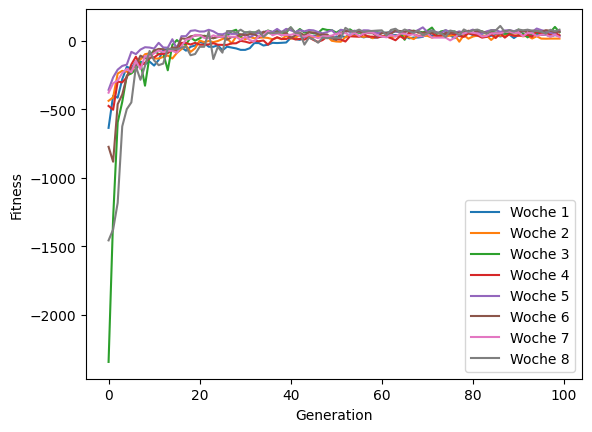

In [8]:
# Visualisierung: Beste Fitnesswerte je Woche über Generationen

for week_number in best_schedule_by_week.keys():
    plt.plot(range(len(best_scores_by_week[week_number])), best_scores_by_week[week_number], label=f'Woche {week_number}')
    
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.show()

#### Erläuterung / Begründung zur Modellierung von Individuen
Die Prüfungspläne der einzelnen Wochen wurden als Individuen definiert und jeweils in wöchentliche Populationen dem evolutionären Optimierungsalgorithmus unterzogen.
Da das Evolutionary Computing nativ und ohne Framework implementiert wurde, war keine separate Modellierung eines Individuums erforderlich sondern die vorgegebene Struktur konnte direkt verwendet werden.

### Anzeige der besten Ergebnisse für alle Wochen nach Evolution

Ein Beispiel wie ausgewertet werden kann. Die Bewertung einer Verletzung der proportionalen Raumzuteilung ist mit -10 festgesetzt (nicht ändern).

In [9]:
def count_slots(schedule):
    slot_count = {}
    
    for day, slots in schedule.items():
        for slot, rooms in slots.items():
            for program in rooms:
                if program not in slot_count:
                    slot_count[program] = 0
                slot_count[program] += 1
    
    return slot_count

def calculate_slot_allocation(week_number, configuration):
    study_programs = configuration['exam_weeks'].get(f"Week {week_number}", [])
    total_courses = sum(configuration['study_programs'][program] for program in study_programs)
    
    # Berechne die proportionalen Slots
    slot_allocation = {}
    for program in study_programs:
        num_courses = configuration['study_programs'][program]
        slot_allocation[program] = round((num_courses / total_courses) * 40)
    return slot_allocation
    
def evaluate_schedule(schedule, configuration):
    # Bewertung basierend auf der Popularität der Slots und Tage
    slot_popularity = configuration['time_slots']
    day_popularity = configuration['days']
    
    score = 0
    for day, slots in schedule.items():
        day_score = day_popularity[day]['popularity']
        for slot, rooms in slots.items():
            slot_score = slot_popularity[slot]['popularity']
            # Addiere die Beliebtheitswerte jedes belegten Slots
            if all(rooms):  # Nur wenn beide Slots belegt sind
                score += (day_score + slot_score)
    
    return score

def calculate_differences_and_penalty(slot_counts, slot_allocations):
    differences = {}
    total_penalty = 0
    
    for program in slot_allocations:
        allocated_slots = slot_allocations.get(program, 0)
        counted_slots = slot_counts.get(program, 0)
        
        difference = counted_slots - allocated_slots
        differences[program] = difference
        
        # Berechne die Strafe basierend auf der Abweichung
        penalty = abs(difference) * -10
        total_penalty += penalty
    
    return differences, total_penalty

for week_number in best_schedule_by_week.keys():
    print(f"##################################################   Woche {week_number}   ##################################################")
    current_best = best_schedule_by_week[week_number]
    # print()
    print_schedule(current_best)
    # Zähle die Slots, die den Studiengängen zugewiesen wurden
    slot_counts = count_slots(current_best)
    print("Slot-Zuweisung pro Studiengang:", slot_counts)

    # Berechne die proportionalen Slot-Zuteilungen
    slot_allocations = calculate_slot_allocation(week_number, configuration)
    print("Proportionale Slot-Zuteilung pro Studiengang:", slot_allocations)

    # Bewertungsfunktion
    schedule_score = evaluate_schedule(current_best, configuration)
    print("Bewertung des Zeitplans:", schedule_score)

    # Berechnungen durchführen
    slot_counts = count_slots(current_best)
    slot_allocations = calculate_slot_allocation(week_number, configuration)

    # Abweichungen und Strafen berechnen
    differences, total_penalty = calculate_differences_and_penalty(slot_counts, slot_allocations)

    # Ausgabe
    print("Abweichungen pro Studiengang:", differences)
    print("Gesamtstrafen:", total_penalty)
    print("Gesamtbewertung:", total_penalty+schedule_score)
    print()


##################################################   Woche 1   ##################################################
-----------------------------------------------------------------------------------------------------------------
Zeit / Tage         Monday             Tuesday            Wednesday            Thursday             Friday       
                R1        R2        R1        R2        R1        R2        R1        R2        R1        R2    
-----------------------------------------------------------------------------------------------------------------
  Slot A       ET        MT       INF       INF        MT        ES        ET        ET        MB        ET    
  Slot B       ET        ES       INF        MT       INF        MB       INF        ET       INF       WIW    
  Slot C      INF       WIW       WIW        MT        ET       INF        MT        MT        ET        ET    
  Slot D      WIW        MB       INF        ET       INF       WIW       WIW       INF       I

### Begründung zum Modell
Die Umsetzung des genetischen Algorithmus folgt einer klar strukturierten und modularen Architektur. Zentrale Komponenten wie die Fitnessfunktion calc_fitness sind getrennt von der eigentlichen Evolutionslogik implementiert, was die Wartbarkeit erhöht und eine flexible Anpassung der Bewertungslogik erlaubt. Durch die Parametrisierung der Bewertungsfaktoren lässt sich das Optimierungsverhalten gezielt steuern, ohne Änderungen am Algorithmus selbst vornehmen zu müssen. Die genetischen Operatoren wie Mutation und Crossover sind explizit als eigene Funktionen realisiert, was die Wiederverwendbarkeit verbessert und eine klare Trennung der Funktionalität sicherstellt.
Außerdem wurde die evolutionäre Optimierung selbst in eine Funktion gekapselt, was es ermöglicht, unterschiedliche Parameterkombinationen effizient zu testen und dabei bestehenden Code wiederzuverwenden, ohne Redundanz durch Kopieren zu erzeugen.

### 2. Test und Bewertung 
Die Tests zeigen, dass das Ergebnis der evolutionären Optimierung stark von der Gewichtung der einzelnen Terme in der Fitnessfunktion abhängt. Werden bestimmte Kriterien relativ gering gewichtet, kann dies zu einer signifikanten Missachtung entsprechender Planungsregeln führen. Der absolute Wert eines Gewichtes ist dabei nicht aussagekräftig, da die Skalen der einzelnen Bewertungsterme unterschiedlich sind. Eine sinnvolle Gewichtung erfordert daher sowohl ein Verständnis der Kriterien als auch ihrer quantitativen Wirkung.

Je nach gewünschter Priorisierung lassen sich durch geeignete Gewichtskombinationen verschiedene Lösungen erzeugen. Die im Code verwendeten Gewichtungen liefern ein ausgewogenes Ergebnis, bei dem alle relevanten Regeln in akzeptablem Maße berücksichtigt werden.

Die Bewertung bleibt jedoch zwangsläufig subjektiv, da in der Aufgabenstellung keine objektiven Bewertungskriterien vorgegeben wurden. Die Festlegung von Gewichtungen basiert daher auf plausiblen Annahmen, spiegelt jedoch individuelle Präferenzen wider. Eine objektivere Bewertung wäre nur möglich, wenn klare Zielmetriken oder Anforderungen explizit definiert wären.


### Diskussion der Ergebnisse
Die Anwendung evolutionärer Algorithmen zur Prüfungsplanung zeigt mehrere vorteilhafte Eigenschaften. Die Methode ist einfach zu implementieren und erlaubt eine flexible Anpassung durch Gewichtung einzelner Bewertungsaspekte. Je nach Priorisierung bestimmter Planungsziele entstehen unterschiedliche, qualitativ akzeptable Lösungen. Die Geschwindigkeit des Algorithmus ist hoch, was insbesondere bei iterativen Optimierungsaufgaben von Vorteil ist. Zudem lassen sich weitere Nebenbedingungen durch Erweiterung der Fitnessfunktion problemlos integrieren.

Gleichzeitig bestehen wesentliche Einschränkungen. Die Definition der Fitnessfunktion ist aufgrund der Vielzahl konkurrierender Anforderungen komplex. Eine zusätzliche Herausforderung stellt die Gewichtung der einzelnen Terme dar, da diese auf unterschiedlichen Skalen operieren und somit ein direkter Vergleich erschwert wird. Die resultierende Optimierung ist nicht deterministisch, was eine Reproduzierbarkeit erschwert und die Bewertung der Ergebnisqualität relativiert.

Insgesamt ermöglicht das evolutionsbasierte Verfahren eine anpassbare und erweiterbare Lösung der Planungsproblematik, erfordert jedoch eine sorgfältige Modellierung und Gewichtung der Zielkriterien.



## Aufgabenteil 2: Constraint Satisfaction Problems

Entwerfen Sie ein KI Modell auf Basis von Constraints und setzen Sie dieses als
Jupyter Notebook um. Wählen Sie geeignete Constraints.

### 1. Variablen bestimmen 

... und ihre Wertebereiche!

In [10]:
def create_variables_for_week(model, configuration, week):
    """
    Erstellt die Variablen für eine einzelne Woche.
    
    Args:
        model: Das OR-Tools CP-Model
        configuration: Dictionary mit der Konfiguration für das Problem
        week: Die zu betrachtende Woche
        
    Returns:
        variables: Dictionary mit den erstellten Variablen
        sg_in_week: Liste der Studiengänge in dieser Woche
    """
    # Daten aus der Konfiguration extrahieren
    days = list(configuration['days'].keys())
    rooms = ['A', 'B']
    slots = [1, 2, 3, 4]

    # Studiengänge in dieser Woche
    sg_in_week = configuration['exam_weeks'][week]

    # Variablen erstellen
    variables = {}
    for day in days:
        for slot_idx in slots:
            for room in rooms:
                var_name = f"slot_{slot_idx}_room_{room}_{day}_{week}"
                # Der Wertebereich ist die Liste der möglichen Studiengänge für diese Woche
                variables[var_name] = model.NewIntVar(
                    0,
                    len(sg_in_week) - 1,
                    var_name
                )

    return variables, sg_in_week

### Begründung zur Wahl der Variablen

Da jeder Zeitslot einer Prüfungswoche von verschiedenen Studiengängen belegt werden kann, ist es sinnvoll, die Slots als Variablen zu modellieren. Der jeweilige Wertebereich dieser Variablen umfasst die Studiengänge, die in der entsprechenden Woche Prüfungen abhalten können.

### 2. Constraints bestimmen

Hier liegt sicher die Hauptaufgabe. Zur Umsetzung als CSP ist ein geeigneter Fairnessrahmen als Grenzwert anzugeben (und als Constraint umzusetzen)

In [ ]:
def add_week_fairness_constraint(model, variables, configuration, sg_in_week, week, fairness_toleranz=0.3):
    """
    Fügt den Fairness-Constraint für eine Woche zum Modell hinzu.
    """
    # Gesamtzahl der Kursgruppen in dieser Woche berechnen
    gesamt_kursgruppen = sum(configuration['study_programs'].get(sg, 0) for sg in sg_in_week)

    # Gesamtzahl der Slots berechnen
    gesamt_slots = len(variables)

    # Für jeden Studiengang in dieser Woche die faire Anzahl an Slots berechnen
    for sg_idx, sg_name in enumerate(sg_in_week):
        # Anzahl der Kursgruppen dieses Studiengangs
        kursgruppen = configuration['study_programs'].get(sg_name, 0)

        # Proportionale Anzahl an Slots berechnen
        faire_slots = (kursgruppen / gesamt_kursgruppen) * gesamt_slots

        # Toleranzbereich definieren
        min_slots = int(faire_slots * (1 - fairness_toleranz))
        max_slots = int(faire_slots * (1 + fairness_toleranz))

        # Zähle, wie viele Slots dem Studiengang zugewiesen wurden
        sg_slots_indicators = []

        for slot_var in variables:
            # Erstelle eine Binärvariable für diesen Slot und Studiengang
            is_sg_assigned = model.NewBoolVar(f"is_sg_{sg_idx}_assigned_to_{slot_var}")

            # Diese Variable ist 1, wenn der Studiengang diesem Slot zugewiesen ist, sonst 0
            model.Add(variables[slot_var] == sg_idx).OnlyEnforceIf(is_sg_assigned)
            model.Add(variables[slot_var] != sg_idx).OnlyEnforceIf(is_sg_assigned.Not())

            sg_slots_indicators.append(is_sg_assigned)

        # Füge den Constraint hinzu, dass die Anzahl der zugewiesenen Slots
        # innerhalb des Toleranzbereichs liegt
        model.Add(sum(sg_slots_indicators) >= min_slots)
        model.Add(sum(sg_slots_indicators) <= max_slots)


def add_week_dominance_constraint(model, variables, configuration, sg_in_week, week, max_slots_per_sg_per_day=4):
    """
    Fügt einen harten Constraint hinzu, der verhindert, dass ein Studiengang zu viele Slots
    an einem Tag in einer Woche belegt.
    """
    # Daten aus der Konfiguration extrahieren
    days = list(configuration['days'].keys())

    # Für jeden Tag und jeden Studiengang
    for day in days:
        for sg_idx, sg_name in enumerate(sg_in_week):
            # Zähle, wie viele Slots diesem Studiengang an diesem Tag zugewiesen wurden
            sg_slots_today = []

            for slot_idx in [1, 2, 3, 4]:
                for room in ['A', 'B']:
                    var_name = f"slot_{slot_idx}_room_{room}_{day}_{week}"
                    if var_name in variables:
                        is_assigned = model.NewBoolVar(f"{var_name}_is_{sg_name}")
                        model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_assigned)
                        model.Add(variables[var_name] != sg_idx).OnlyEnforceIf(is_assigned.Not())
                        sg_slots_today.append(is_assigned)

            # Begrenze die Anzahl der Slots, die ein Studiengang an einem Tag belegen darf
            if sg_slots_today:
                model.Add(sum(sg_slots_today) <= max_slots_per_sg_per_day)


def add_previous_assignments_constraints(model, variables, sg_in_week, week, unpopular_terms, unpopular_days, unpopular_slot_indices, configuration):
    # Daten aus der Konfiguration extrahieren
    days = list(configuration['days'].keys())

    # Berechne die relative Größe jedes Studiengangs
    total_groups = sum(configuration['study_programs'].values())
    relative_sizes = {sg: groups / total_groups for sg, groups in configuration['study_programs'].items()}

    # Berechne die ideale Verteilung unbeliebter Termine basierend auf relativer Größe
    total_unpopular = sum(unpopular_terms.values())

    # Für jeden Studiengang
    for sg_idx, sg_name in enumerate(sg_in_week):
        # Relative Größe dieses Studiengangs
        size_factor = relative_sizes.get(sg_name, 0)

        # Idealwert für unbeliebte Termine für diesen Studiengang
        # basierend auf bisheriger Gesamtzahl und relativer Größe
        ideal_unpopular = total_unpopular * size_factor if total_unpopular > 0 else 0

        # Aktuelle Anzahl unbeliebter Termine
        current_unpopular = unpopular_terms.get(sg_name, 0)

        # Wenn der Studiengang bereits mehr als seinen fairen Anteil hat,
        # begrenzen wir strenger die neuen unbeliebten Termine
        if current_unpopular > ideal_unpopular * 1.1:  # 10% Toleranz
            # Zähle potenzielle neue unbeliebte Termine
            unpopular_count = []

            # Unbeliebte Tage
            for day in unpopular_days:
                for slot_idx in range(1, 5):
                    for room in ['A', 'B']:
                        var_name = f"slot_{slot_idx}_room_{room}_{day}_{week}"
                        if var_name in variables:
                            is_assigned = model.NewBoolVar(f"{var_name}_is_{sg_name}_unpopular_day")
                            model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_assigned)
                            model.Add(variables[var_name] != sg_idx).OnlyEnforceIf(is_assigned.Not())
                            unpopular_count.append(is_assigned)

            # Unbeliebte Zeitslots
            for day in days:
                for slot_idx in unpopular_slot_indices:
                    for room in ['A', 'B']:
                        var_name = f"slot_{slot_idx}_room_{room}_{day}_{week}"
                        if var_name in variables:
                            is_assigned = model.NewBoolVar(f"{var_name}_is_{sg_name}_unpopular_slot")
                            model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_assigned)
                            model.Add(variables[var_name] != sg_idx).OnlyEnforceIf(is_assigned.Not())
                            unpopular_count.append(is_assigned)

            # Begrenze die Anzahl neuer unbeliebter Termine
            # Je stärker die Abweichung, desto strikter die Begrenzung
            if unpopular_count:
                if current_unpopular > ideal_unpopular * 1.5:
                    # Sehr streng, nur 1 neuer unbeliebter Termin erlaubt
                    max_new_unpopular = 1
                elif current_unpopular > ideal_unpopular * 1.25:
                    # Streng, nur 2 neue unbeliebte Termine erlaubt
                    max_new_unpopular = 2
                else:
                    # Normal, 3 neue unbeliebte Termine erlaubt
                    max_new_unpopular = 3

                model.Add(sum(unpopular_count) <= max_new_unpopular)


def add_week_soft_constraints(model, variables, configuration, sg_in_week, week):
    """
    Fügt die weichen Constraints als Teil der Zielfunktion für eine Woche hinzu.
    
    Args:
        model: Das OR-Tools CP-Model
        variables: Dictionary mit den Variablen für diese Woche
        configuration: Dictionary mit der Konfiguration für das Problem
        sg_in_week: Liste der Studiengänge in dieser Woche
        week: Die betrachtete Woche
        
    Returns:
        Liste der Terme für die Zielfunktion
    """

    # Daten aus der Konfiguration extrahieren
    days = list(configuration['days'].keys())

    # Liste der Studiengänge mit mehreren Kursgruppen
    study_programs_with_more_than_one_course = [
        sg for sg in sg_in_week if configuration['study_programs'].get(sg, 0) > 1
    ]

    # Zielfunktionsterme
    objective_terms = []

    # 1. Weicher Constraint: Studiengänge mit mehreren Kursgruppen sollten
    # beide Räume gleichzeitig nutzen können
    parallel_weight = configuration.get('room_popularity', {}).get('parallel', 7)

    for day in days:
        for slot_idx in [1, 2, 3, 4]:
            # Für jeden Tag und Zeitslot
            var_name_a = f"slot_{slot_idx}_room_A_{day}_{week}"
            var_name_b = f"slot_{slot_idx}_room_B_{day}_{week}"

            if var_name_a not in variables or var_name_b not in variables:
                continue

            # Für jeden Studiengang mit mehreren Kursgruppen
            for sg_name in study_programs_with_more_than_one_course:
                if sg_name in sg_in_week:
                    sg_idx = sg_in_week.index(sg_name)

                    # Erstelle eine Binärvariable, die angibt, ob der Studiengang
                    # beide Räume gleichzeitig nutzt
                    uses_both_rooms = model.NewBoolVar(
                        f"sg_{sg_name}_uses_both_rooms_{day}_{slot_idx}_{week}"
                    )

                    # Diese Variable ist 1, wenn der Studiengang beide Räume nutzt
                    model.Add(variables[var_name_a] == sg_idx).OnlyEnforceIf(uses_both_rooms)
                    model.Add(variables[var_name_b] == sg_idx).OnlyEnforceIf(uses_both_rooms)

                    # Füge einen Bonus zur Zielfunktion hinzu
                    objective_terms.append(uses_both_rooms * parallel_weight)

    # 2. Weicher Constraint: Zeitslot-Popularität berücksichtigen
    slot_names = ["Slot A", "Slot B", "Slot C", "Slot D"]

    for var_name, var in variables.items():
        # Extrahiere den Slot-Index aus dem Variablennamen
        parts = var_name.split('_')
        slot_idx = int(parts[1])

        # Entsprechenden Zeitslot und seine Popularität ermitteln
        slot_name = slot_names[slot_idx-1]
        slot_popularity = configuration['time_slots'][slot_name]['popularity']

        # Für jeden Studiengang eine Bewertung basierend auf dem Zeitslot hinzufügen
        for sg_idx in range(len(sg_in_week)):
            is_assigned = model.NewBoolVar(f"{var_name}_is_sg_{sg_idx}")
            model.Add(var == sg_idx).OnlyEnforceIf(is_assigned)

            # Füge einen Bonus basierend auf der Slot-Popularität hinzu
            objective_terms.append(is_assigned * slot_popularity)

    # 3. Weicher Constraint: Wochentag-Popularität berücksichtigen
    for var_name, var in variables.items():
        # Extrahiere den Tag aus dem Variablennamen
        parts = var_name.split('_')
        day_index = parts.index(week) - 1
        day = parts[day_index]

        # Popularität des Tages ermitteln
        day_popularity = configuration['days'][day]['popularity']

        # Für jeden Studiengang eine Bewertung basierend auf dem Tag hinzufügen
        for sg_idx in range(len(sg_in_week)):
            is_assigned = model.NewBoolVar(f"{var_name}_is_day_{sg_idx}")
            model.Add(var == sg_idx).OnlyEnforceIf(is_assigned)

            # Füge einen Bonus basierend auf der Tag-Popularität hinzu
            objective_terms.append(is_assigned * day_popularity)

    # 4. Weicher Constraint: Sequentielle Prüfungen
    sequential_weight = configuration.get('room_popularity', {}).get('sequential', 5)

    for day in days:
        for sg_idx in range(len(sg_in_week)):
            # Prüfe für aufeinanderfolgende Zeitslots
            for slot_idx in range(1, 4):  # Slots 1, 2, 3 (da wir den nachfolgenden betrachten)
                # Variablen für aktuelle und nächste Zeitslots
                current_slots = []
                next_slots = []

                for room in ['A', 'B']:
                    current_var_name = f"slot_{slot_idx}_room_{room}_{day}_{week}"
                    next_var_name = f"slot_{slot_idx+1}_room_{room}_{day}_{week}"

                    if current_var_name not in variables or next_var_name not in variables:
                        continue

                    current_is_sg = model.NewBoolVar(f"{current_var_name}_is_sg_{sg_idx}")
                    next_is_sg = model.NewBoolVar(f"{next_var_name}_is_sg_{sg_idx}")

                    model.Add(variables[current_var_name] == sg_idx).OnlyEnforceIf(current_is_sg)
                    model.Add(variables[next_var_name] == sg_idx).OnlyEnforceIf(next_is_sg)

                    current_slots.append(current_is_sg)
                    next_slots.append(next_is_sg)

                # Für jede Kombination prüfen, ob aufeinanderfolgende Slots
                # vom gleichen Studiengang belegt werden
                for current in current_slots:
                    for next_slot in next_slots:
                        sequential = model.NewBoolVar(
                            f"sg_{sg_idx}_sequential_{day}_{slot_idx}_{week}"
                        )
                        model.AddBoolAnd([current, next_slot]).OnlyEnforceIf(sequential)

                        # Füge einen Bonus zur Zielfunktion hinzu
                        objective_terms.append(sequential * sequential_weight)

    # 5. Weicher Constraint: Vermeidung ungünstiger Abfolgen (spät/früh)
    for day_idx in range(len(days) - 1):
        day = days[day_idx]
        next_day = days[day_idx + 1]

        # Für jeden Studiengang
        for sg_idx in range(len(sg_in_week)):
            # Prüfe, ob der Studiengang einen späten Slot heute hat
            has_late_today = []
            for slot_idx in [3, 4]:  # Späte Slots
                for room in ['A', 'B']:
                    var_name = f"slot_{slot_idx}_room_{room}_{day}_{week}"
                    if var_name in variables:
                        is_late = model.NewBoolVar(f"{var_name}_is_late_for_sg_{sg_idx}")
                        model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_late)
                        has_late_today.append(is_late)

            # Prüfe, ob der Studiengang einen frühen Slot morgen hat
            has_early_tomorrow = []
            for slot_idx in [1, 2]:  # Frühe Slots
                for room in ['A', 'B']:
                    var_name = f"slot_{slot_idx}_room_{room}_{next_day}_{week}"
                    if var_name in variables:
                        is_early = model.NewBoolVar(f"{var_name}_is_early_for_sg_{sg_idx}")
                        model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_early)
                        has_early_tomorrow.append(is_early)

            # Füge eine Strafe für ungünstige Abfolgen hinzu, wenn relevante Variablen vorhanden sind
            if has_late_today and has_early_tomorrow:
                for late in has_late_today:
                    for early in has_early_tomorrow:
                        bad_sequence = model.NewBoolVar(
                            f"sg_{sg_idx}_bad_sequence_{day}_{next_day}_{week}"
                        )
                        model.AddBoolAnd([late, early]).OnlyEnforceIf(bad_sequence)

                        # Füge eine negative Gewichtung zur Zielfunktion hinzu
                        objective_terms.append(bad_sequence.Not() * 25)  # Hohe Gewichtung

    # 6. Weicher Constraint: Täglicher Slot für jeden Studiengang
    for day in days:
        for sg_idx in range(len(sg_in_week)):
            # Prüfe, ob der Studiengang an diesem Tag mindestens einen Slot hat
            has_slot_today = []

            for slot_idx in [1, 2, 3, 4]:
                for room in ['A', 'B']:
                    var_name = f"slot_{slot_idx}_room_{room}_{day}_{week}"
                    if var_name in variables:
                        is_assigned = model.NewBoolVar(f"{var_name}_is_assigned_to_sg_{sg_idx}")
                        model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_assigned)
                        has_slot_today.append(is_assigned)

            # Wenn es relevante Variablen gibt
            if has_slot_today:
                # Erstelle eine Variable, die angibt, ob der Studiengang
                # an diesem Tag mindestens einen Slot hat
                has_any_slot = model.NewBoolVar(f"sg_{sg_idx}_has_slot_{day}_{week}")
                model.AddBoolOr(has_slot_today).OnlyEnforceIf(has_any_slot)
                model.AddBoolAnd([var.Not() for var in has_slot_today]).OnlyEnforceIf(has_any_slot.Not())

                # Füge einen Bonus zur Zielfunktion hinzu
                objective_terms.append(has_any_slot * 15)

    return objective_terms




def solve_week_with_dynamic_constraints(configuration, week, unpopular_terms, time_limit=120, fairness_tolerances = [0.3, 0.35, 0.4], max_slots_per_sg_per_day=4):
    """
    Löst das Problem mit anpassbaren Parametern für umfassendes Testen.
    
    Args:
        configuration: Problemkonfiguration
        week: Zu lösende Woche
        unpopular_terms: Bisherige Verteilung unbeliebter Termine
        fairness_tolerances: Liste von Fairness-Toleranzen, vom strengsten zum lockersten
        max_slots_per_sg_per_day: Maximale Anzahl Slots pro Studiengang pro Tag
        time_limit: Zeitlimit in Sekunden
        
    Returns:
        Lösung oder None, wenn keine gefunden wurde
    """

    # Analysiere die bisherige Verteilung
    total_groups = sum(configuration['study_programs'].values())
    relative_sizes = {sg: groups / total_groups for sg, groups in configuration['study_programs'].items()}

    total_unpopular = sum(unpopular_terms.values())

    # Berechne ideale Verteilung
    ideal_unpopular = {
        sg: total_unpopular * size_factor if total_unpopular > 0 else 0
        for sg, size_factor in relative_sizes.items()
    }

    # Berechne Abweichungen
    deviations = {
        sg: unpopular_terms.get(sg, 0) - ideal
        for sg, ideal in ideal_unpopular.items()
    }

    print(f"\nAbweichungen vor Woche {week}:")
    for sg, dev in sorted(deviations.items(), key=lambda x: x[1], reverse=True):
        if abs(dev) > 1:
            print(f"  {sg}: {dev:+.1f} vom Idealwert")

    
    

    for tolerance in fairness_tolerances:
        print(f"Versuche Lösung für {week} mit Fairness-Toleranz {tolerance}...")

        # Modell erstellen
        model = cp_model.CpModel()

        # Variablen erstellen
        variables, sg_in_week = create_variables_for_week(model, configuration, week)

        # Harter Constraint: Fairness für diese Woche
        add_week_fairness_constraint(model, variables, configuration, sg_in_week, week, fairness_toleranz=tolerance)

        # Harter Constraint: Begrenze die Dominanz eines Studiengangs pro Tag
        add_week_dominance_constraint(model, variables, configuration, sg_in_week, week, max_slots_per_sg_per_day)

        # Identifiziere unbeliebte Tage und Slots
        days = list(configuration['days'].keys())
        day_popularities = {day: config['popularity'] for day, config in configuration['days'].items()}

        # Passe die Anzahl der unbeliebten Tage basierend auf der Toleranz an
        if tolerance == 0.3:
            num_unpopular_days = 2
        else:
            num_unpopular_days = 1

        unpopular_days = sorted(days, key=lambda d: day_popularities[d])[:num_unpopular_days]

        # Ähnliches Vorgehen für Slots
        slot_names = list(configuration['time_slots'].keys())
        time_slot_popularities = {slot: config['popularity'] for slot, config in configuration['time_slots'].items()}
        unpopular_slots = sorted(slot_names, key=lambda s: time_slot_popularities[s])[:num_unpopular_days]

        # Slot-Namen zu Indizes konvertieren
        slot_indices = {"Slot A": 1, "Slot B": 2, "Slot C": 3, "Slot D": 4}
        unpopular_slot_indices = [slot_indices[slot] for slot in unpopular_slots]

        # Füge speziell für Studiengänge mit zu vielen unbeliebten Terminen restriktivere Constraints hinzu
        for sg_idx, sg_name in enumerate(sg_in_week):
            if sg_name in deviations and deviations[sg_name] > 3:  # Wenn mehr als 3 über dem Idealwert
                # Zähle potenzielle neue unbeliebte Termine
                unpopular_count = []

                # Unbeliebte Tage und Slots zusammenfassen
                for day in unpopular_days:
                    for slot_idx in range(1, 5):
                        for room in ['A', 'B']:
                            var_name = f"slot_{slot_idx}_room_{room}_{day}_{week}"
                            if var_name in variables:
                                is_assigned = model.NewBoolVar(f"{var_name}_is_{sg_name}_unpopular")
                                model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_assigned)
                                model.Add(variables[var_name] != sg_idx).OnlyEnforceIf(is_assigned.Not())
                                unpopular_count.append(is_assigned)

                for day in days:
                    for slot_idx in unpopular_slot_indices:
                        for room in ['A', 'B']:
                            var_name = f"slot_{slot_idx}_room_{room}_{day}_{week}"
                            if var_name in variables:
                                is_assigned = model.NewBoolVar(f"{var_name}_is_{sg_name}_unpopular")
                                model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_assigned)
                                model.Add(variables[var_name] != sg_idx).OnlyEnforceIf(is_assigned.Not())
                                unpopular_count.append(is_assigned)

                # Maximal erlaubte neue unbeliebte Termine basierend auf der Abweichung
                max_new = max(1, int(5 - deviations[sg_name]/3))

                if unpopular_count:
                    model.Add(sum(unpopular_count) <= max_new)

        # Constraints basierend auf bisherigen Zuweisungen bei allen Toleranzen
        add_previous_assignments_constraints(model, variables, sg_in_week, week, unpopular_terms,
                                             unpopular_days, unpopular_slot_indices, configuration)

        # Weiche Constraints als Teil der Zielfunktion
        objective_terms = add_week_soft_constraints(model, variables, configuration, sg_in_week, week)

        # Zielfunktion maximieren
        model.Maximize(sum(objective_terms))

        # Lösung finden
        solver = cp_model.CpSolver()
        solver.parameters.max_time_in_seconds = time_limit
        status = solver.Solve(model)

        # Wenn eine Lösung gefunden wurde, zurückgeben
        if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
            solution = {}
            for var_name, var in variables.items():
                sg_idx = solver.Value(var)
                sg_name = sg_in_week[sg_idx]
                solution[var_name] = sg_name

                # Zähle unbeliebte Termine für diesen Studiengang
                parts = var_name.split('_')
                slot_idx = int(parts[1])
                day = parts[4]

                if day in unpopular_days or slot_idx in unpopular_slot_indices:
                    unpopular_terms[sg_name] = unpopular_terms.get(sg_name, 0) + 1

            print(f"Lösung für {week} gefunden mit Toleranz {tolerance}, Status: {status}")
            print(f"Objektiver Wert: {solver.ObjectiveValue()}")

            return solution

    # Wenn keine Lösung mit allen Toleranzen gefunden wurde
    print(f"Keine Lösung für {week} mit dynamischen Constraints gefunden.")
    return None


def solve_multi_week_sequential(configuration, time_limit_per_week=120, fairness_tolerances = [0.3, 0.35, 0.4], max_slots_per_sg_per_day=4):
    """
    Löst das Klausurslotverteilungsproblem sequentiell Woche für Woche.
    """
    weeks = list(configuration['exam_weeks'].keys())
    complete_solution = {}

    # Zähle die Zuweisungen zu unbeliebten Terminen
    unpopular_terms = {sg: 0 for sg in configuration['study_programs']}

    # Löse für jede Woche einzeln
    for week in weeks:
        # Erste Versuch: Mit Standard-Constraints
        week_solution = solve_week_with_dynamic_constraints(configuration, week, unpopular_terms, time_limit_per_week, fairness_tolerances, max_slots_per_sg_per_day)
 
        complete_solution[week] = week_solution

        # Ausgabe der aktuellen Verteilung unbeliebter Termine
        print("\nAktuelle Verteilung unbeliebter Termine:")
        for sg, count in sorted(unpopular_terms.items(), key=lambda x: x[1], reverse=True):
            if count > 0:
                print(f"  {sg}: {count} unbeliebte Termine")

    return complete_solution



def display_solution(solution, configuration, week):
    """
    Zeigt die gefundene Lösung für eine Woche an.
    """
    if solution is None or week not in solution:
        print(f"Keine Lösung für Woche {week} vorhanden.")
        return

    # Tage und Slots extrahieren
    days = list(configuration['days'].keys())
    slots = ["8:00-10:00", "10:30-12:30", "13:00-15:00", "15:30-17:30"]

    # Lösung anzeigen
    print(f"\nStundenplan für {week}:")
    print("-" * 80)

    # Kopfzeile mit den Tagen
    header = "Zeitslot       | "
    for day in days:
        header += f"{day:^12} | "
    print(header)
    print("-" * 80)

    # Zeilen für jeden Zeitslot
    for slot_idx, slot_time in enumerate(slots, 1):
        row = f"{slot_time} | "

        for day in days:
            room_a_var = f"slot_{slot_idx}_room_A_{day}_{week}"
            room_b_var = f"slot_{slot_idx}_room_B_{day}_{week}"

            room_a = solution[week].get(room_a_var, "-")
            room_b = solution[week].get(room_b_var, "-")

            cell = f"A:{room_a}, B:{room_b}"
            row += f"{cell:^12} | "

        print(row)
    print("-" * 80)


def display_all_solutions(solution, configuration):
    """
    Zeigt die gefundenen Lösungen für alle Wochen an.
    """
    if solution is None:
        print("Keine Lösung vorhanden.")
        return

    # Für jede Woche die Lösung anzeigen
    for week in solution.keys():
        display_solution(solution, configuration, week)

def analyze_and_rebalance_solution(solution, configuration):
    """Analysiert die Gesamtlösung und identifiziert Ungleichgewichte."""

    if solution is None:
        print("Keine Lösung zum Analysieren vorhanden.")
        return {}, {}, {}
    
    # Zähle unbeliebte Termine pro Studiengang
    unpopular_counts = {sg: 0 for sg in configuration['study_programs']}

    # Identifiziere unbeliebte Tage und Slots
    days = list(configuration['days'].keys())
    day_popularities = {day: config['popularity'] for day, config in configuration['days'].items()}
    unpopular_days = sorted(days, key=lambda d: day_popularities[d])[:2]

    slot_names = list(configuration['time_slots'].keys())
    time_slot_popularities = {slot: config['popularity'] for slot, config in configuration['time_slots'].items()}
    unpopular_slots = sorted(slot_names, key=lambda s: time_slot_popularities[s])[:2]

    # Slot-Namen zu Indizes konvertieren
    slot_indices = {"Slot A": 1, "Slot B": 2, "Slot C": 3, "Slot D": 4}
    unpopular_slot_indices = [slot_indices[slot] for slot in unpopular_slots]

    # Zähle für jede Woche
    for week, week_solution in solution.items():
        if week_solution is None:
            print(f"Keine Lösung für {week} vorhanden.")
            continue

        valid_solution_found = True
        for var_name, sg_name in week_solution.items():
            parts = var_name.split('_')
            slot_idx = int(parts[1])
            day = parts[4]

            if day in unpopular_days or slot_idx in unpopular_slot_indices:
                unpopular_counts[sg_name] = unpopular_counts.get(sg_name, 0) + 1
    # Wenn keine gültige Lösung gefunden wurde, frühzeitig beenden
    if not valid_solution_found:
        print("Keine gültige Wochenlösung in der Gesamtlösung gefunden.")
        return {}, {}, {}
    
    # Berechne die ideale proportionale Verteilung
    total_groups = sum(configuration['study_programs'].values())
    total_unpopular = sum(unpopular_counts.values())

    ideal_distribution = {
        sg: (groups / total_groups) * total_unpopular
        for sg, groups in configuration['study_programs'].items()
    }

    # Finde Studiengänge mit zu vielen/wenigen unbeliebten Terminen
    deviations = {
        sg: unpopular_counts.get(sg, 0) - ideal
        for sg, ideal in ideal_distribution.items()
    }

    # Ausgabe der Analyse
    print("\nAnalyse der Gesamtlösung:")
    print("Studiengang | Kursgruppen | Unbeliebte Termine | Ideal | Abweichung")
    print("-" * 70)

    for sg in sorted(configuration['study_programs'].keys()):
        groups = configuration['study_programs'][sg]
        unpopular = unpopular_counts.get(sg, 0)
        ideal = ideal_distribution[sg]
        dev = deviations[sg]

        print(f"{sg:^10} | {groups:^11} | {unpopular:^17} | {ideal:^5.1f} | {dev:^10.1f}")

    # TODO: Hier könnte man einen Algorithmus zur Neuverteilung implementieren
    # für Studiengänge mit zu großen Abweichungen

    return unpopular_counts, ideal_distribution, deviations

def run_multi_week_sequential(configuration):
    """
    Führt das CSP-Modell für die Klausurslotverteilung sequentiell für mehrere Wochen aus.
    """
    # Löse das Problem für alle Wochen sequentiell
    solution = solve_multi_week_sequential(configuration)

    # Zeige die Lösung an
    if solution:
        display_all_solutions(solution, configuration)

    return solution

solution = run_multi_week_sequential(configuration)
print(solution)


Abweichungen vor Woche Week 1:
Versuche Lösung für Week 1 mit Fairness-Toleranz 0.3...
Lösung für Week 1 gefunden mit Toleranz 0.3, Status: 2
Objektiver Wert: 10505.0

Aktuelle Verteilung unbeliebter Termine:
  ET: 8 unbeliebte Termine
  INF: 7 unbeliebte Termine
  MT: 5 unbeliebte Termine
  MB: 4 unbeliebte Termine
  WIW: 3 unbeliebte Termine
  ES: 1 unbeliebte Termine

Abweichungen vor Woche Week 2:
  MB: +1.2 vom Idealwert
  WIW: -1.2 vom Idealwert
  INF: -1.4 vom Idealwert
Versuche Lösung für Week 2 mit Fairness-Toleranz 0.3...
Lösung für Week 2 gefunden mit Toleranz 0.3, Status: 2
Objektiver Wert: 10505.0

Aktuelle Verteilung unbeliebter Termine:
  INF: 20 unbeliebte Termine
  ET: 10 unbeliebte Termine
  WIW: 9 unbeliebte Termine
  MT: 8 unbeliebte Termine
  MB: 6 unbeliebte Termine
  ES: 3 unbeliebte Termine

Abweichungen vor Woche Week 3:
  INF: +3.2 vom Idealwert
  ET: -4.0 vom Idealwert
Versuche Lösung für Week 3 mit Fairness-Toleranz 0.3...
Versuche Lösung für Week 3 mit Fai

### Begründungen 

## Harte Constraints
Der Code stellt sicher, dass jeder Studiengang eine proportionale Anzahl an Slots entsprechend seiner Größe (Kursgruppen) erhält. Die Funktion add_week_fairness_constraint implementiert dies mit einem Toleranzbereich (standardmäßig 30 %), der bei Bedarf schrittweise auf 35 % oder 40 % erhöht werden kann, falls keine Lösung gefunden wird. Mit add_week_dominance_constraint wird verhindert, dass ein Studiengang zu viele Slots an einem Tag belegt (maximal 4), um Studierende nicht zu überlasten. Die Funktion add_previous_assignments_constraints berücksichtigt bereits zugewiesene unbeliebte Termine aus vorherigen Wochen, um Fairness über den gesamten Prüfungszeitraum zu gewährleisten. Studiengänge mit überproportional vielen unbeliebten Terminen werden in aktuellen Zuweisungen weniger mit weiteren solchen Terminen belastet.

## Weiche Constraints
In add_week_soft_constraints werden mehrere Präferenzen als gewichtete Faktoren in die Zielfunktion einbezogen:
- Parallelnutzung von Räumen: Bonus für Studiengänge mit mehreren Kursgruppen, wenn sie beide Räume gleichzeitig nutzen können.
- Zeitslot-Popularität: Vormittags Prüfungen werden bevorzugt.
- Wochentag-Popularität: Die Beliebtheit verschiedener Wochentage wird berücksichtigt.
- Sequentielle Prüfungen: Bonus für aufeinanderfolgende Prüfungen desselben Studiengangs.
- Vermeidung ungünstiger Abfolgen: Hohe Strafpunkte, wenn ein Studiengang einen späten Slot an einem Tag und einen frühen am nächsten Tag hat.
- Täglicher Slot für jeden Studiengang: Bonus, wenn ein Studiengang mindestens einen Slot pro Tag erhält. 

## Adaptiver Lösungsansatz
Das Modell nutzt einen sequentiellen Ansatz, der jede Prüfungswoche einzeln löst, aber Informationen aus vorherigen Wochen berücksichtigt. Der dynamische Constraints-Ansatz (solve_week_with_dynamic_constraints) kann Toleranzparameter automatisch anpassen, wenn keine Lösung gefunden wird. Ein Fallback-Mechanismus mit noch lockereren Constraints steht als letzte Option zur Verfügung.
Die implementierten Constraints bilden ein Gleichgewicht zwischen Fairness, pädagogischen Überlegungen, organisatorischer Effizienz und studentischen Präferenzen, was die Anforderungen der Aufgabenstellung umfassend erfüllt.

### 3. Test und Bewertung

Die Verteilung der unbeliebten Termine (Freitag, Slot 4) scheint angemessen balanciert zu sein. Freitagstermine werden oft auf alle Studiengänge verteilt, und die späten Slots (Slot 4) werden nicht übermäßig einem einzelnen Studiengang zugewiesen. Allerdings haben größere Studiengänge wie INF und ET tendenziell mehr unbeliebte Slots, was aber proportional zu ihrer Größe angemessen erscheint. Die Lösung scheint die Möglichkeit, dass Studiengänge mit mehreren Kursgruppen beide Räume gleichzeitig belegen, sehr effektiv zu nutzen. Außerdem scheint das Modell häufig aufeinanderfolgende Prüfungen für denselben Studiengang zu bevorzugen, was für die Organisation vorteilhaft ist. Ungünstige Abfolgen (späte Slots gefolgt von frühen Slots am nächsten Tag) kommen einigermaßen häufig vor, obwohl die Gewichtung des entsprechenden Constraints recht hoch ist. Es könnte sein, dass der Solver keine Lösung finden kann, die alle ungünstigen Abfolgen vermeidet und gleichzeitig alle harten Constraints erfüllt. Insgesamt werden ungünstige Abfolgen aber größtenteils vermieden. Zudem haben die Studiengänge oft, aber nicht immer, an jedem Tag mindestens einen Slot. 

Die folgende Funktion erlaubt es verschiedene Konfigurationen für fairness-tolerance, die maximalen slots pro Tag für eine Kursgruppe und Gewichtungen der weichen Constraints zu testen und die Ergebnisse zu vergleichen. Aus Performance-Gruenden werden lediglich acht Kombinatonen getestet. 


Teste Konfiguration: fairness=[0.25, 0.3, 0.35], max_slots=3, parallel=5, sequential=3

Abweichungen vor Woche Week 1:
Versuche Lösung für Week 1 mit Fairness-Toleranz 0.25...
Lösung für Week 1 gefunden mit Toleranz 0.25, Status: 2
Objektiver Wert: 10435.0

Aktuelle Verteilung unbeliebter Termine:
  MB: 5 unbeliebte Termine
  ET: 4 unbeliebte Termine
  MT: 3 unbeliebte Termine
  INF: 2 unbeliebte Termine
  ES: 1 unbeliebte Termine
  WIW: 1 unbeliebte Termine

Abweichungen vor Woche Week 2:
  MB: +3.4 vom Idealwert
  WIW: -1.4 vom Idealwert
  INF: -2.8 vom Idealwert
Versuche Lösung für Week 2 mit Fairness-Toleranz 0.25...
Lösung für Week 2 gefunden mit Toleranz 0.25, Status: 2
Objektiver Wert: 10435.0

Aktuelle Verteilung unbeliebter Termine:
  INF: 9 unbeliebte Termine
  ET: 8 unbeliebte Termine
  MB: 6 unbeliebte Termine
  MT: 4 unbeliebte Termine
  WIW: 3 unbeliebte Termine
  ES: 2 unbeliebte Termine

Abweichungen vor Woche Week 3:
  MB: +2.8 vom Idealwert
  WIW: -1.8 vom Idealwert


C:\Users\b43579\AppData\Local\Temp\ipykernel_27216\4095327838.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=parallel_unique)


[{'params': {'fairness_tolerances': [0.35, 0.4, 0.45],
   'max_slots': 3,
   'parallel_weight': 5,
   'sequential_weight': 3},
  'solution': {'Week 1': {'slot_1_room_A_Monday_Week 1': 'INF',
    'slot_1_room_B_Monday_Week 1': 'ES',
    'slot_2_room_A_Monday_Week 1': 'MT',
    'slot_2_room_B_Monday_Week 1': 'ET',
    'slot_3_room_A_Monday_Week 1': 'ET',
    'slot_3_room_B_Monday_Week 1': 'ET',
    'slot_4_room_A_Monday_Week 1': 'WIW',
    'slot_4_room_B_Monday_Week 1': 'MB',
    'slot_1_room_A_Tuesday_Week 1': 'MT',
    'slot_1_room_B_Tuesday_Week 1': 'INF',
    'slot_2_room_A_Tuesday_Week 1': 'INF',
    'slot_2_room_B_Tuesday_Week 1': 'INF',
    'slot_3_room_A_Tuesday_Week 1': 'WIW',
    'slot_3_room_B_Tuesday_Week 1': 'WIW',
    'slot_4_room_A_Tuesday_Week 1': 'ET',
    'slot_4_room_B_Tuesday_Week 1': 'MB',
    'slot_1_room_A_Wednesday_Week 1': 'ET',
    'slot_1_room_B_Wednesday_Week 1': 'MT',
    'slot_2_room_A_Wednesday_Week 1': 'ET',
    'slot_2_room_B_Wednesday_Week 1': 'ET',
    

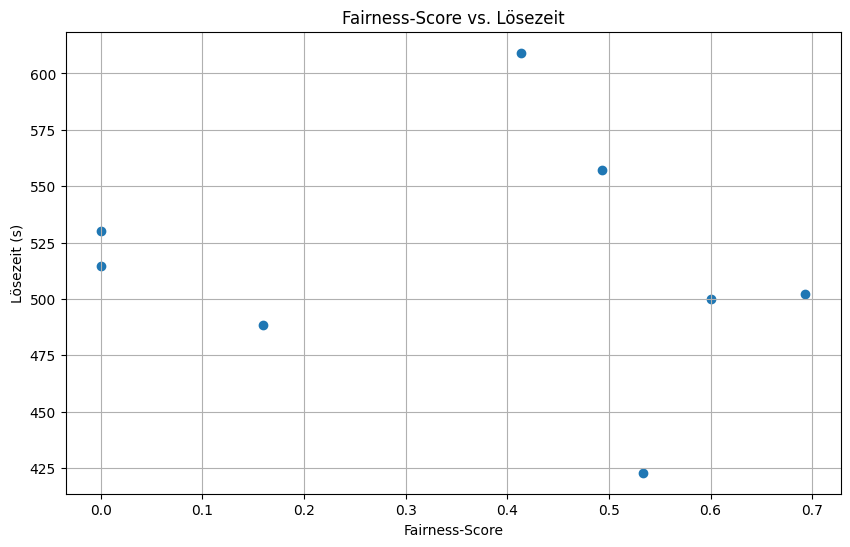

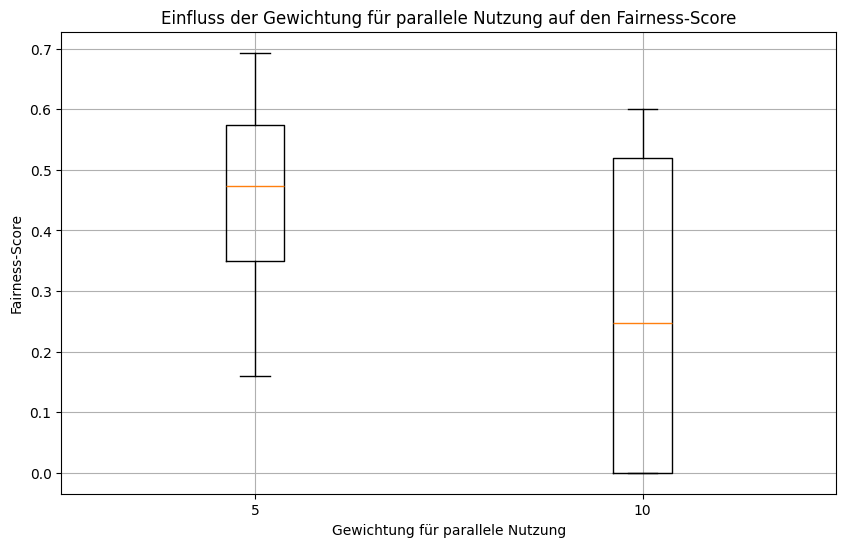

In [12]:
def test_different_configurations():
    import copy
    import time
    import json
    import matplotlib.pyplot as plt

    # Lade die Basiskonfiguration
    with open('configuration_003.json', 'r') as f:
        base_configuration = json.load(f)

    # Parameter zum Testen
    fairness_tolerances_options = [[0.25, 0.3, 0.35], [0.35, 0.4, 0.45]]
    max_slots_options = [3]
    parallel_weights = [5, 10]
    sequential_weights = [3, 7]

    results = []

    # Teste eine Auswahl von Parameterkombinationen
    for fairness_tolerances in fairness_tolerances_options:
        for max_slots in max_slots_options:
            for parallel_weight in parallel_weights:
                for sequential_weight in sequential_weights:
                    # Erstelle eine Kopie der Konfiguration und passe sie an
                    test_config = copy.deepcopy(base_configuration)
                    test_config['room_popularity']['parallel'] = parallel_weight
                    test_config['room_popularity']['sequential'] = sequential_weight

                    print(f"\nTeste Konfiguration: fairness={fairness_tolerances}, "
                          f"max_slots={max_slots}, parallel={parallel_weight}, "
                          f"sequential={sequential_weight}")

                    # Messe die Zeit
                    start_time = time.time()

                    # Löse das Problem mit dieser Konfiguration
                    solution = solve_multi_week_sequential(
                        test_config,
                        fairness_tolerances=fairness_tolerances,
                        max_slots_per_sg_per_day=max_slots
                    )

                    solve_time = time.time() - start_time

                    if solution:
                        # Bewerte die Lösung
                        unpopular_counts, ideal_distribution, deviations = analyze_and_rebalance_solution(
                            solution, test_config
                        )

                        # Berechne einen Gesamtscore für die Lösung
                        fairness_score = calculate_fairness_score(deviations)

                        # Speichere das Ergebnis
                        results.append({
                            'params': {
                                'fairness_tolerances': fairness_tolerances,
                                'max_slots': max_slots,
                                'parallel_weight': parallel_weight,
                                'sequential_weight': sequential_weight
                            },
                            'solution': solution,
                            'fairness_score': fairness_score,
                            'solve_time': solve_time
                        })

                        print(f"Lösung gefunden mit Fairness-Score: {fairness_score:.2f} in {solve_time:.2f} Sekunden")
                    else:
                        print("Keine Lösung gefunden!")

    # Sortiere die Ergebnisse nach Fairness-Score
    sorted_results = sorted(results, key=lambda x: x['fairness_score'], reverse=True)

    # Zeige die besten Ergebnisse
    print("\n=== Beste Konfigurationen ===")
    for i, result in enumerate(sorted_results[:5]):
        params = result['params']
        print(f"{i+1}. Fairness={params['fairness_tolerances']}, Max Slots={params['max_slots']}, "
              f"Parallel={params['parallel_weight']}, Sequential={params['sequential_weight']}")
        print(f"   Fairness-Score: {result['fairness_score']:.2f}, Zeit: {result['solve_time']:.2f}s")

    # Visualisiere die Ergebnisse
    visualize_results(sorted_results)

    return sorted_results

def calculate_fairness_score(deviations):
    """Berechnet einen Fairness-Score basierend auf den Abweichungen."""
    # Kleinere Abweichungen sind besser, also invertieren wir die durchschnittliche Abweichung
    avg_deviation = sum(abs(dev) for dev in deviations.values()) / len(deviations)
    # Normalisiere auf einen Wert zwischen 0 und 1 (mit 0.5 als Schwellenwert)
    return max(0, 1 - avg_deviation / 5)  # 5 ist ein willkürlicher Normalisierungsfaktor

def visualize_results(results):
    """Visualisiert die Testergebnisse."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Extrahiere Parameter und Scores
    fairness_tolerances = [str(r['params']['fairness_tolerances']) for r in results]
    max_slots = [r['params']['max_slots'] for r in results]
    parallel_weights = [r['params']['parallel_weight'] for r in results]
    sequential_weights = [r['params']['sequential_weight'] for r in results]
    fairness_scores = [r['fairness_score'] for r in results]
    solve_times = [r['solve_time'] for r in results]

    # 1. Fairness-Score vs. Lösezeit
    plt.figure(figsize=(10, 6))
    plt.scatter(fairness_scores, solve_times)
    plt.xlabel('Fairness-Score')
    plt.ylabel('Lösezeit (s)')
    plt.title('Fairness-Score vs. Lösezeit')
    plt.grid(True)
    plt.savefig('fairness_vs_time.png')

    # 2. Einfluss von parallel_weight auf Fairness-Score
    parallel_unique = sorted(set(parallel_weights))
    parallel_scores = {w: [] for w in parallel_unique}

    for r in results:
        parallel_scores[r['params']['parallel_weight']].append(r['fairness_score'])

    plt.figure(figsize=(10, 6))
    box_data = [parallel_scores[w] for w in parallel_unique]
    plt.boxplot(box_data, labels=parallel_unique)
    plt.xlabel('Gewichtung für parallele Nutzung')
    plt.ylabel('Fairness-Score')
    plt.title('Einfluss der Gewichtung für parallele Nutzung auf den Fairness-Score')
    plt.grid(True)
    plt.savefig('parallel_weight_influence.png')



test_different_configurations()

### Diskussion der Ergebnisse 

Die Ergebnisse des Vergleichs sind mit Vorsicht zu betrachten, da lediglich acht verschiedene Kombinationen untersucht werden. Die Tests zeigen dennoch interessante Einblicke in die Parameter. Die höheren Fairness-Toleranz-Werte ([0.35, 0.4, 0.45]) führten im Durchschnitt zu besseren Fairness-Scores als die niedrigeren Werte ([0.25, 0.3, 0.35]). Die besten Scores (0.55 und 0.49) wurden mit der höheren Fairness-Toleranz erreicht. Die Funktion analyze_and_rebalance_solution konzentriert sich bei der Bewertung auf die Verteilung unbeliebter Termine. Gibt aber dennoch eine gute Orientierung für die Ergebnisse. Eine niedrigere Gewichtung für parallele Raumnutzung (5) führte konsistent zu besseren Fairness-Scores als die höhere Gewichtung (10). Der Einfluss des Parameters Sequential Weight ist weniger eindeutig. Bei niedrigerer Fairness-Toleranz scheint sequential=3 besser zu sein. Bei höherer Fairness-Toleranz ist das Ergebnis gemischt. Um den Einfluss des Parameters max_slots zu evaluieren, sollte dieser ebenfalls noch mit unterschiedlichen Werten getestet werden.

Die beste Parameterkombination aus den Tests:
- Fairness-Toleranz: [0.35, 0.4, 0.45]
- Max Slots pro Tag: 3
- Parallele Raumnutzung: 5
- Sequentielle Prüfungen: 3
Diese Kombination erzielte einen Fairness-Score von 0.55 bei einer Laufzeit von etwa 503 Sekunden.

Eine höhere Fairness-Toleranz verbessert den Fairness-Score. Möglicherweise kann der Solver mit mehr Flexibilität bessere Lösungen finden, die insgesamt fairer sind, da mehr Spielraum für Optimierungen besteht. Die Gewichtungen für parallele Raumnutzung und sequentielle Prüfungen haben einen erheblichen Einfluss auf die Fairness-Scores. Dies zeigt, dass die weichen Constraints tatsächlich das Lösungsverhalten steuern. Für einige Wochen wurde keine Lösung gefunden, da solve_week_with_dynamic_constraints None zurückgegeben hat. Aus diesem Grund sollte der Fallback-Mechanismus verbessert werden, um in solchen Fällen trotzdem eine akzeptable Lösung zu finden. Die Laufzeiten waren relativ konstant, unabhängig von der Parameterwahl. Allgemein gibt es einen Trade-off zwischen der strikten Einhaltung der Fairness und anderen Zielen (wie parallele oder sequentielle Nutzung).

# Abschluss

Vergleich der beiden Verfahren. Ggf. ist hier noch Code zum Vergleich zu ergänzen, ansonsten weitgehend durch Text.

In [13]:
# Convert CSP Solution to the structure of a schedule
start_week = 1
end_week = 8
days = list(configuration['days'].keys())
rooms = ['A','B']

csp_schedules_by_week = {}
for week_number in range(start_week,end_week+1):
    csp_schedules_by_week[week_number] = {}
    for day in days:
        csp_schedules_by_week[week_number][day] = {}
        slot_numer = 1
        for slot_name in list(configuration['time_slots'].keys()):
            csp_schedules_by_week[week_number][day][slot_name] = []
            for room in rooms:
                var_name = f'slot_{slot_numer}_room_{room}_{day}_Week {week_number}'
                program = solution[f'Week {week_number}'][var_name]
                csp_schedules_by_week[week_number][day][slot_name].append(program)
            slot_numer += 1

In [14]:
from collections import Counter, defaultdict
from prettytable import PrettyTable

def count_parallel_slots(schedule):
    out = {}
    for day in schedule:
        for slot in schedule[day]:
            counter = Counter(schedule[day][slot])
            for program in counter:
                if counter[program] > 1:
                    if not program in out:
                        out[program] = 0
                    out[program] += 1
    return out

def count_consecutive_slots(schedule):
    out = {}
    for day in schedule:
        for i in range(1,len(schedule[day])):
            prev_key = list(schedule[day])[i-1]
            key = list(schedule[day])[i]
            prev_slot = schedule[day][prev_key]
            slot = schedule[day][key]
            for k in range(0,len(slot)):
                if(slot[k] in prev_slot):
                    if slot[k] not in out:
                        out[slot[k]] = 0
                    out[slot[k]] += 1
    return out

def count_late_early(schedule):
    out = {}
    for i in range(1,len(schedule)):
        prev_day = list(schedule)[i-1]
        day = list(schedule)[i]
        last_slot_prey_day = list(schedule[prev_day].values())[-1]
        first_slot_this_day = list(schedule[day].values())[0]
        for program in last_slot_prey_day:
            if program in first_slot_this_day:
                if program not in out:
                    out[program] = 0
                out[program] += 1
    return out
        

def count_days_with_slots(schedule):
    number_of_days_by_program = {}
    for day in schedule:
        programs_this_day = []
        for slot in schedule[day]:
            for program in schedule[day][slot]:
                programs_this_day.append(program)
        for program in set(programs_this_day):
            if program not in number_of_days_by_program:
                number_of_days_by_program[program] = 0
            number_of_days_by_program[program] += 1
    return number_of_days_by_program

def get_programs_in_week(configuration,week_number):
    return configuration['exam_weeks'][f'Week {week_number}']

def print_summary_table(schedule,week_number,configuration):
    parallel_count = count_parallel_slots(schedule)
    consecutive_count = count_consecutive_slots(schedule)

    late_early_count = count_late_early(schedule)
    day_count = count_days_with_slots(schedule)
    
    programs_this_week = get_programs_in_week(configuration,week_number)

    slot_counts = count_slots(schedule)
    slot_allocations = calculate_slot_allocation(week_number, configuration)
    differences, total_penalty = calculate_differences_and_penalty(slot_counts, slot_allocations)

    t = PrettyTable()
    header_row = ['',*programs_this_week]

    t.field_names = header_row
    
    parallel_row = ['parallel slots']
    consecutive_row = ['consecutive slots']
    late_early_row = ['late early slots']
    day_row = ['number of days with slots']
    number_of_slots_row = ['numbrer of slots']
    proportional_slots_row = ['proportinaly needed slots']
    difference_slots_row = ['slot number differences']
    for program in programs_this_week:
        parallel_row.append(parallel_count.get(program,0))
        consecutive_row.append(consecutive_count.get(program,0))
        late_early_row.append(late_early_count.get(program,0))
        day_row.append(day_count.get(program,0))
        number_of_slots_row.append(slot_counts.get(program,0))
        proportional_slots_row.append(slot_allocations.get(program,0))
        difference_slots_row.append(differences.get(program,0))
    t.add_rows([
        parallel_row,
        consecutive_row,
        late_early_row,
        day_row,
        number_of_slots_row,
        proportional_slots_row,
        difference_slots_row
    ])
    print(t)


def print_sum_of_metrics(schedules_array):
    metrics_sum_by_program = {}
    for program in configuration['study_programs']:
        metrics_sum_by_program[program] = {}

    for week_number in schedules_array.keys():
        schedule = schedules_array[week_number]
        parallel_count = count_parallel_slots(schedule)
        consecutive_count = count_consecutive_slots(schedule)

        late_early_count = count_late_early(schedule)
        day_count = count_days_with_slots(schedule)

        slot_counts = count_slots(schedule)
        slot_allocations = calculate_slot_allocation(week_number, configuration)
        differences, total_penalty = calculate_differences_and_penalty(slot_counts, slot_allocations)
        metrics = {
            'parallel slots': parallel_count,
            'consecutive slots': consecutive_count,
            'late early slots': late_early_count,
            'number of days with slots': day_count,
            'numbrer of slots': slot_counts,
            'proportinaly needed slots': slot_allocations,
            'slot number differences': differences
        }
        for program in get_programs_in_week(configuration,week_number):
            for metric_name in metrics:
                if not metric_name in metrics_sum_by_program[program]:
                    metrics_sum_by_program[program][metric_name] = 0
                metrics_sum_by_program[program][metric_name] += metrics[metric_name].get(program,0)
    
    table = PrettyTable()
    table.field_names = [""] + list(metrics_sum_by_program.keys())
    for key in list(metrics.keys()):
        row = [key]
        for col in metrics_sum_by_program:
            row.append(metrics_sum_by_program[col][key])
        table.add_row(row)
    print(table)

for week_number in best_schedule_by_week.keys():
    print(f"##################################################   Woche {week_number}   ##################################################")
    schedule_ea = best_schedule_by_week[week_number]
    schedule_csp = csp_schedules_by_week[week_number]

    print(f"############   ERGEBNIS EA   ############")
    print_summary_table(schedule_ea,week_number,configuration)
    print_schedule(schedule_ea)
    print(f"############   ERGEBNIS CSP   ############")
    print_summary_table(schedule_csp,week_number,configuration)
    print_schedule(schedule_csp)
    # print('EA:',calc_fitness(schedule_ea,week_number,configuration))
    # print('CSP:',calc_fitness(schedule_csp,week_number,configuration))

print(f"#############################################################################################################################")
print(f"##################################################         Gesamt         ###################################################")
print(f"#############################################################################################################################")
print('EA:')
print_sum_of_metrics(best_schedule_by_week)
print('CSP:')
print_sum_of_metrics(csp_schedules_by_week)


##################################################   Woche 1   ##################################################
############   ERGEBNIS EA   ############
+---------------------------+----+----+----+----+-----+-----+
|                           | MB | MT | ES | ET | WIW | INF |
+---------------------------+----+----+----+----+-----+-----+
|       parallel slots      | 0  | 1  | 0  | 2  |  0  |  2  |
|     consecutive slots     | 0  | 1  | 0  | 2  |  1  |  3  |
|      late early slots     | 0  | 0  | 0  | 0  |  0  |  0  |
| number of days with slots | 3  | 4  | 2  | 5  |  5  |  5  |
|      numbrer of slots     | 3  | 6  | 2  | 10 |  6  |  13 |
| proportinaly needed slots | 4  | 6  | 2  | 10 |  6  |  12 |
|  slot number differences  | -1 | 0  | 0  | 0  |  0  |  1  |
+---------------------------+----+----+----+----+-----+-----+
-----------------------------------------------------------------------------------------------------------------
Zeit / Tage         Monday             Tuesday  

# Fazit
Zwischen den Verfahren zeigen sich Unterschiede, deren Ausprägung je nach Ausführungsdurchlauf variiert. Konstant lassen sich jedoch zwei Tendenzen beobachten:
- Parallele Slots: CSP erzeugt konsistent eine höhere Anzahl paralleler Veranstaltungen als EA.
- Abweichung von der proportionalen Slotanzahl: EA hält die Sollvorgabe stabiler ein, während CSP größere Abweichungen zeigt.

Die beobachteten Schwankungen lassen sich vermutlich auf die stochastische Natur beider Verfahren zurückführen. Sowohl CSP als auch EA enthalten Zufallskomponenten, die bei wiederholter Ausführung zu unterschiedlichen Ergebnissen führen können.

Die Unterschiede beider Algorithmen bei parallelen Slots und der Abweichung von der proportionalen Slotzahl lassen sich auf die unterschiedliche Gewichtung innerhalb der Fitnessfunktion bzw. der Constraints zurückführen. Je nach Wahl dieser Gewichte könnten die Unterschiede auch anders ausfallen. Es lässt sich daher nicht gesichert sagen, welches Verfahren einen "besseren" Plan erzeugt, zumal keine objektive Definition von "besser" in diesem Kontext existiert.

Der signifikanteste Unterschied liegt in der Laufzeit: Die Lösung des CSP benötigt je nach Hardware 5-10 Minuten, während der evolutionäre Algorithmus mit 100 Generationen nur etwa eine Minute benötigt.
